# Advanced Multi-Modal Retrieval using GPT4V (vision) and Multi-Modal Index/Retriever
Alejandro Ricciardi (Omegapy)  
created date: 01/01/2024
GitHub: https://github.com/Omegapy

Projects Description:
Multi-Modal retrieval system using LlamaIndex with GPT4-V and CLIP.
Tutorial from LlamaIndex.

LlamaIndex Multi-Modal Retrieval

- Text embedding index: Generate GPT text embeddings
- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Encoding queries:
* Encode query text for text index using ada
* Encode query text for image index using CLIP

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Using Multi-Modal LLM GPT4V class to understand multiple images
2. Download texts, images, pdf raw files from related Wikipedia articles and SEC 10K report
2. Build Multi-Modal index and vector store for both texts and images
4. Retrieve relevant text and image simultaneously using Multi-Modal Retriever according to the image reasoning from Step 1

credit: 
[LlamaIndex Youtube video](https://www.youtube.com/watch?v=35RlrrgYDyU)
[Jupyter Notebook: Multi-modal retrieval and querying](https://colab.research.google.com/gist/seldo/057406cf3b49a3ed41f9f17a02930996/gpt4v_multi_modal_retrieval.ipynb#scrollTo=3bbc9a0e)


#### Installing Dependencies 

In [1]:
%pip install git+https://github.com/run-llama/llama_index.git
# Clip Dependencies 
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
# Matplotlib Dependencies
%pip install matplotlib scikit-image
# qdrant is vector similarity search engine [https://qdrant.tech/documentation/overview/]
%pip install -U qdrant_client
# wikipedia
%pip install wikipedia

  Cloning https://github.com/run-llama/llama_index.git to c:\users\user\appdata\local\temp\pip-req-build-ji51abah
  Resolved https://github.com/run-llama/llama_index.git to commit 8f659705dd7f032e8d204ca860ab654bdf7ab0c3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/run-llama/llama_index.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-ji51abah'
  Running command git submodule update --init --recursive -q


Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-mm_g7318
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-mm_g7318'


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### API Keys
This project you require API keys from: OpenAI: https://openai.com/ 

In [2]:
# Load environment variables API Keys
import os
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv()) 
OPENAI_API_KEY = os.environ.get("OPEN_AI_KEY")

## Plot input images

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

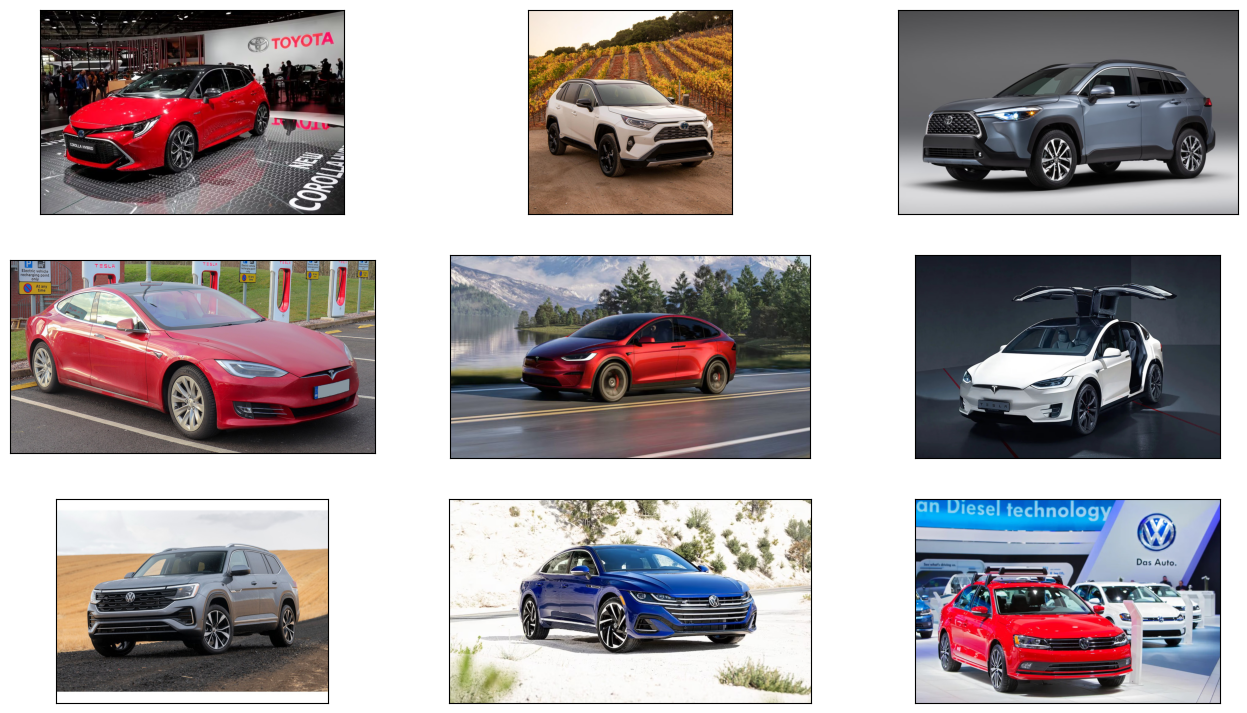

In [4]:
image_paths = []
for img_path in os.listdir("./cars"):
    image_paths.append(str(os.path.join("./cars", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

## Using GPT4V to understand those input images

In [5]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader

image_documents = SimpleDirectoryReader(input_files=["./cars/o1.jpg","./cars/t1.jpg","./cars/v1.jpg"]).load_data()


In [6]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

response_1 = openai_mm_llm.complete(
    prompt="Describe the car in the image, if you can not provide visual descriptions of the images I uploaded, tell me why",
    image_documents=image_documents,
)

print(response_1)

The first image shows a red Toyota Corolla Hybrid car. It's a modern hatchback model with a sporty design, featuring sharp lines and angles, especially around the headlights and lower front bumper area. The car is displayed at an auto show with the Toyota logo prominently displayed in the background.

The second image is of a red Tesla Model S, an all-electric luxury sedan. It has a sleek, aerodynamic design with a smooth body shape and a distinctive Tesla front grille, which is a solid panel due to the lack of a traditional internal combustion engine.

The third image features a silver Volkswagen Atlas, a mid-size SUV. It has a robust and sturdy appearance with a large grille, wide stance, and strong body lines that give it a commanding presence. The vehicle is positioned on what appears to be a dirt road, emphasizing its SUV capabilities.


In [7]:
# delete qdrant data base file, window sys.
!rmdir /s /q qdrant_mm_db
# Unix and Unix-like operating systems 
# !rm -rf qdrant_mm_db

The system cannot find the file specified.


## Build Multi-modal index and vector store to index both text and images

In [8]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./cars").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

## Query text and images from our Multi-Modal Index
### Find Toyota

In [9]:
# generate Text retrieval results
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
retrieval_results = retriever_engine.retrieve("Find the Toyotas")

**Node ID:** a7f2ffa9-1a22-41b0-8b42-a95be47dfb19<br>**Similarity:** 0.827842080640869<br>**Text:** Toyota is a Japanese multinational automotive manufacturer headquartered in Toyota City, Aichi, Japan.<br>

**Node ID:** 8fcc4567-1d61-4ddf-8bf2-9b6bd162045f<br>**Similarity:** 0.8062143420753924<br>**Text:** After World War II, Toyota benefited from Japan's alliance with the United States to learn from American automakers and other companies, which gave rise to The Toyota Way (a management philosophy) ...<br>

**Node ID:** 1572ec0c-817d-43ed-a722-459ca8218441<br>**Similarity:** 0.802329555344742<br>**Text:** Toyota was praised for being a leader in the development and sales of more fuel-efficient hybrid electric vehicles, starting with the introduction of the Toyota Prius in 1997. The company now sells...<br>

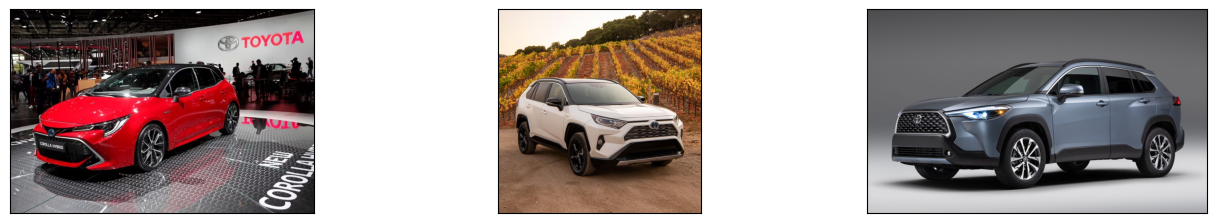

In [10]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

### Find Telsa

In [11]:
# generate Text retrieval results
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)
retrieval_results = retriever_engine.retrieve("Find the Teslas")

**Node ID:** 1d0f3cfe-b459-4075-aaea-fd88d53f6d7c<br>**Similarity:** 0.82459152064456<br>**Text:** Tesla, Inc is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs and manufactures electric vehicles<br>

**Node ID:** c8921ec8-f513-4fb3-bfd5-e18968014a36<br>**Similarity:** 0.8184997634533111<br>**Text:** Tesla was incorporated in July 2003 by Martin Eberhard and Marc Tarpenning as Tesla Motors. The company's name is a tribute to inventor and electrical engineer Nikola Tesla. In February 2004, via a...<br>

**Node ID:** efeb6423-65a4-4cb1-9c90-4d976a6bae6d<br>**Similarity:** 0.8049700090156271<br>**Text:** Tesla has been the subject of lawsuits, government scrutiny, and journalistic criticism, stemming from allegations of whistleblower retaliation, worker rights violations, product defects, and Musk'...<br>

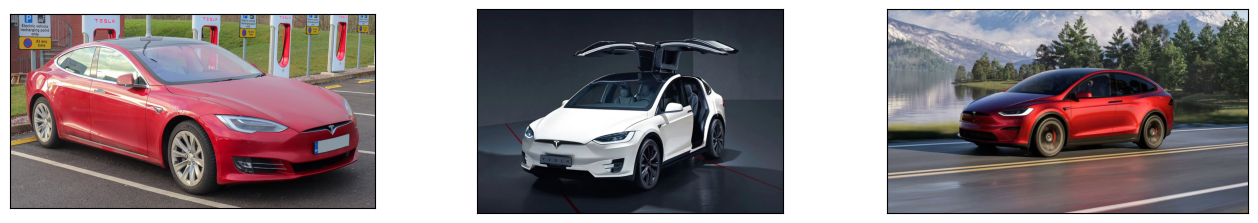

In [12]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

## Compare Toyotas Images
Using a query engine

In [13]:
query_engine = index.as_query_engine(
    similarity_top_k=3, image_similarity_top_k=3
)
response = query_engine.query("Compare the toyotas")
print(response)

Based on the images provided:

1. The first image shows a red Toyota Corolla Hybrid, which is a compact car that features a combination of a gasoline engine and an electric motor, making it more fuel-efficient than traditional gasoline-only vehicles. The Corolla Hybrid is part of Toyota's extensive lineup of hybrid vehicles, which aligns with the company's reputation for being a leader in the development and sales of hybrid electric vehicles.

2. The second image features a Toyota SUV, which appears to be a newer model with a modern design. It's larger than the Corolla Hybrid, offering more space and possibly more utility. This vehicle may also come with different powertrain options, including hybrid versions, depending on the specific model and market.

3. The third image is another Toyota SUV, which also showcases a contemporary design and is likely equipped with modern features and technology. Similar to the second image, this SUV is designed to cater to consumers who need more spac